<a href="https://colab.research.google.com/github/aniketsharma00411/CMPUT655-Project/blob/main/rl_project_experiment_structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.ppo import PPOConfig
from popgym.envs import labyrinth_escape, labyrinth_explore

import os
import pickle
import json

import pprint
import matplotlib.pyplot as plt

# Configuration

In [2]:
num_of_cycles = 2 #@param
total_timesteps_per_cycle = 12000 #@param

In [3]:
ray.init()

2023-11-28 02:21:48,526	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.9.18
Ray version:,2.3.0


# Defining Environments

In [4]:
envs = ["LabyrinthEscapeEasy", "LabyrinthEscapeMedium", "LabyrinthEscapeHard", "LabyrinthExploreEasy", "LabyrinthExploreMedium", "LabyrinthExploreHard"]

ray.tune.registry.register_env("LabyrinthEscapeEasy", lambda env_config: labyrinth_escape.LabyrinthEscapeEasy())
ray.tune.registry.register_env("LabyrinthEscapeMedium", lambda env_config: labyrinth_escape.LabyrinthEscapeMedium())
ray.tune.registry.register_env("LabyrinthEscapeHard", lambda env_config: labyrinth_escape.LabyrinthEscapeHard())
ray.tune.registry.register_env("LabyrinthExploreEasy", lambda env_config: labyrinth_explore.LabyrinthExploreEasy())
ray.tune.registry.register_env("LabyrinthExploreMedium", lambda env_config: labyrinth_explore.LabyrinthExploreMedium())
ray.tune.registry.register_env("LabyrinthExploreHard", lambda env_config: labyrinth_explore.LabyrinthExploreHard())

# Defining Model

In [5]:
model = {"use_attention": True}

# Running Experiments

In [6]:
mean_reward_per_episode = {}
timesteps_done = {}
for env in envs:
    mean_reward_per_episode[env] = []
    timesteps_done[env] = []

previous_checkpoint_path = None

In [7]:
! mkdir saved_weights

/bin/bash: /home/aniket7/miniconda3/envs/rl_project/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: cannot create directory ‘saved_weights’: File exists


In [8]:
os.cpu_count()

64

In [9]:
total_timesteps = 0
prev_env_timesteps = 0
for cycle_count in range(num_of_cycles):
    for env in envs:
        print(f'Starting Cycle {cycle_count} Environment {env}:')
        config = {
            "env": env,
            "num_cpus": 11,  # https://discuss.ray.io/t/total-workers-number-of-gpus-1/9292/2
            "num_gpus": 4,
            "num_gpus_per_worker": 1,
            "num_cpus_per_worker": 2,
            "num_cpus_for_local_worker": 3,
            "model": model,
            "framework": "torch"
        }

        trainer = PPOTrainer(env=env, config=config)
        if previous_checkpoint_path is not None:
            trainer.restore(previous_checkpoint_path+'/'+sorted(os.listdir(previous_checkpoint_path))[-1])

        previous_checkpoint_path = f"saved_checkpoints/agent_cycle_{cycle_count}_env_{env}"
        curr_env_timesteps = 0
        #variables to check whether algorithm has reached weight save points
        start_checkpoint = False
        midway_checkpoint = False
        while curr_env_timesteps < total_timesteps_per_cycle:
            result = trainer.train()

            mean_reward_per_episode[env].append(result['episode_reward_mean'])
            pprint.pprint(result)
            total_timesteps = result['timesteps_total']
            curr_env_timesteps = total_timesteps - prev_env_timesteps
            timesteps_done[env].append(curr_env_timesteps)

            # save weights when training checkpoints are reached
            # 1 represents start checkpoint and 2 is midway checkpoint
            if not start_checkpoint and curr_env_timesteps > 0:
                print('Saving weights: Timesteps ', curr_env_timesteps)
                with open(f'saved_weights/weights_cycle_{cycle_count}_env_{env}_stage_1.pkl', 'wb') as f:
                    weights = trainer.get_weights()
                    pickle.dump(weights, f)
                start_checkpoint = True

            if not midway_checkpoint and curr_env_timesteps >= total_timesteps_per_cycle / 2:
                print('Saving weights: Timesteps ', curr_env_timesteps)
                with open(f'saved_weights/weights_cycle_{cycle_count}_env_{env}_stage_2.pkl', 'wb') as f:
                    weights = trainer.get_weights()
                    pickle.dump(weights, f)
                midway_checkpoint = True

        trainer.save(previous_checkpoint_path)

        prev_env_timesteps = total_timesteps

        print('\n\n')

2023-11-28 02:21:50,432	WARNING algorithm_config.py:596 -- Cannot create PPOConfig from given `config_dict`! Property num_cpus not supported.
2023-11-28 02:21:50,433	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthEscapeEasy', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthEscapeEasy').build()` instead. This will raise an error in the future!
2023-11-28 02:21:50,467	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


Starting Cycle 0 Environment LabyrinthEscapeEasy:


(RolloutWorker pid=707290) 2023-11-28 02:21:54,128	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=707290) 2023-11-28 02:21:54,128	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-11-28 02:21:56,161	WARNING util.py:67 -- Install gputil for GPU system monitoring.


{'agent_timesteps_total': 4000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function':

2023-11-28 02:24:58,257	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthEscapeMedium', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthEscapeMedium').build()` instead. This will raise an error in the future!


Saving weights: Timesteps  8000
{'agent_timesteps_total': 12000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
  

(RolloutWorker pid=719077) 2023-11-28 02:25:01,926	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=719077) 2023-11-28 02:25:01,926	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-11-28 02:25:02,808	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-11-28 02:25:02,840	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_0_env_LabyrinthEscapeEasy/checkpoint_000003
2023-11-28 02:25:02,840	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 181.94058060646057, '_episodes_total': 13}


{'agent_timesteps_total': 16000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function'

2023-11-28 02:28:32,779	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthEscapeHard', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthEscapeHard').build()` instead. This will raise an error in the future!


Saving weights: Timesteps  8000
{'agent_timesteps_total': 24000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
  

(RolloutWorker pid=730618) 2023-11-28 02:28:36,487	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=730618) 2023-11-28 02:28:36,487	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-11-28 02:28:37,391	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-11-28 02:28:37,425	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_0_env_LabyrinthEscapeMedium/checkpoint_000006
2023-11-28 02:28:37,425	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 391.7550935745239, '_episodes_total': 24}


{'agent_timesteps_total': 28000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function'

2023-11-28 02:31:53,717	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthExploreEasy', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthExploreEasy').build()` instead. This will raise an error in the future!


Saving weights: Timesteps  8000
{'agent_timesteps_total': 36000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
  

(RolloutWorker pid=743045) 2023-11-28 02:31:57,431	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=743045) 2023-11-28 02:31:57,431	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-11-28 02:31:58,339	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-11-28 02:31:58,369	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_0_env_LabyrinthEscapeHard/checkpoint_000009
2023-11-28 02:31:58,369	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 9, '_timesteps_total': None, '_time_total': 587.9189670085907, '_episodes_total': 35}


{'agent_timesteps_total': 40000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function'

2023-11-28 02:35:14,927	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthExploreMedium', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthExploreMedium').build()` instead. This will raise an error in the future!


Saving weights: Timesteps  8000
{'agent_timesteps_total': 48000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
  

(RolloutWorker pid=754511) 2023-11-28 02:35:18,570	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=754511) 2023-11-28 02:35:18,570	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-11-28 02:35:19,484	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-11-28 02:35:19,517	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_0_env_LabyrinthExploreEasy/checkpoint_000012
2023-11-28 02:35:19,518	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 12, '_timesteps_total': None, '_time_total': 784.3664827346802, '_episodes_total': 45}


{'agent_timesteps_total': 52000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function'

2023-11-28 02:38:39,385	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthExploreHard', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthExploreHard').build()` instead. This will raise an error in the future!


Saving weights: Timesteps  8000
{'agent_timesteps_total': 60000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
  

(RolloutWorker pid=765981) 2023-11-28 02:38:43,021	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=765981) 2023-11-28 02:38:43,021	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-11-28 02:38:43,955	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-11-28 02:38:43,988	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_0_env_LabyrinthExploreMedium/checkpoint_000015
2023-11-28 02:38:43,989	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 15, '_timesteps_total': None, '_time_total': 984.1315422058105, '_episodes_total': 55}


{'agent_timesteps_total': 64000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function'

2023-11-28 02:42:04,287	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthEscapeEasy', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthEscapeEasy').build()` instead. This will raise an error in the future!


Saving weights: Timesteps  8000
{'agent_timesteps_total': 72000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
  

(RolloutWorker pid=777454) 2023-11-28 02:42:08,012	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=777454) 2023-11-28 02:42:08,012	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-11-28 02:42:08,908	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-11-28 02:42:08,943	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_0_env_LabyrinthExploreHard/checkpoint_000018
2023-11-28 02:42:08,943	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 18, '_timesteps_total': None, '_time_total': 1184.314321756363, '_episodes_total': 65}


{'agent_timesteps_total': 76000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function'

2023-11-28 02:45:31,917	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthEscapeMedium', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthEscapeMedium').build()` instead. This will raise an error in the future!


Saving weights: Timesteps  8000
{'agent_timesteps_total': 84000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
  

(RolloutWorker pid=788811) 2023-11-28 02:45:35,571	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=788811) 2023-11-28 02:45:35,572	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-11-28 02:45:36,492	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-11-28 02:45:36,525	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_1_env_LabyrinthEscapeEasy/checkpoint_000021
2023-11-28 02:45:36,526	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 21, '_timesteps_total': None, '_time_total': 1387.1544427871704, '_episodes_total': 77}


{'agent_timesteps_total': 88000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function'

2023-11-28 02:48:55,894	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthEscapeHard', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthEscapeHard').build()` instead. This will raise an error in the future!


Saving weights: Timesteps  8000
{'agent_timesteps_total': 96000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
  

(RolloutWorker pid=800152) 2023-11-28 02:48:59,545	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=800152) 2023-11-28 02:48:59,546	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-11-28 02:49:00,462	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-11-28 02:49:00,493	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_1_env_LabyrinthEscapeMedium/checkpoint_000024
2023-11-28 02:49:00,493	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 24, '_timesteps_total': None, '_time_total': 1586.4024820327759, '_episodes_total': 88}


{'agent_timesteps_total': 100000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

2023-11-28 02:52:19,315	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthExploreEasy', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthExploreEasy').build()` instead. This will raise an error in the future!


Saving weights: Timesteps  8000
{'agent_timesteps_total': 108000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
 

(RolloutWorker pid=811605) 2023-11-28 02:52:22,971	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=811605) 2023-11-28 02:52:22,972	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-11-28 02:52:23,864	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-11-28 02:52:23,896	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_1_env_LabyrinthEscapeHard/checkpoint_000027
2023-11-28 02:52:23,897	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 27, '_timesteps_total': None, '_time_total': 1785.1126053333282, '_episodes_total': 98}


{'agent_timesteps_total': 112000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

2023-11-28 02:55:42,488	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthExploreMedium', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthExploreMedium').build()` instead. This will raise an error in the future!


Saving weights: Timesteps  8000
{'agent_timesteps_total': 120000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
 

(RolloutWorker pid=823071) 2023-11-28 02:55:46,212	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=823071) 2023-11-28 02:55:46,212	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-11-28 02:55:47,115	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-11-28 02:55:47,145	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_1_env_LabyrinthExploreEasy/checkpoint_000030
2023-11-28 02:55:47,145	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1983.5876326560974, '_episodes_total': 108}


{'agent_timesteps_total': 124000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

2023-11-28 02:59:06,808	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='LabyrinthExploreHard', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('LabyrinthExploreHard').build()` instead. This will raise an error in the future!


Saving weights: Timesteps  8000
{'agent_timesteps_total': 132000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
 

(RolloutWorker pid=834559) 2023-11-28 02:59:10,517	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=834559) 2023-11-28 02:59:10,517	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-11-28 02:59:11,349	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-11-28 02:59:11,380	INFO trainable.py:791 -- Restored on 129.128.243.187 from checkpoint: saved_checkpoints/agent_cycle_1_env_LabyrinthExploreMedium/checkpoint_000033
2023-11-28 02:59:11,380	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 33, '_timesteps_total': None, '_time_total': 2183.1362659931183, '_episodes_total': 118}


{'agent_timesteps_total': 136000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_enable_rl_module_api': False,
            '_enable_rl_trainer_api': False,
            '_fake_gpus': False,
            '_rl_trainer_hps': RLTrainerHPs(),
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'always_attach_evaluation_results': False,
            'auto_wrap_old_gym_envs': True,
            'batch_mode': 'truncate_episodes',
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'checkpoint_trainable_policies_only': False,
            'clip_actions': False,
            'clip_param': 0.3,
            'clip_rewards': None,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function

In [10]:
ray.shutdown()

In [11]:
mean_reward_per_episode

{'LabyrinthEscapeEasy': [-0.6214192708333334,
  -0.50634765625,
  -0.4560546875,
  -0.12451171875,
  -0.4080810546875,
  -0.6050618489583334],
 'LabyrinthEscapeMedium': [-0.9990234375,
  -0.9990234375,
  -0.8718927556818182,
  -0.4248046875,
  -0.6708984375,
  -0.7902166193181818],
 'LabyrinthEscapeHard': [-0.572265625,
  -0.8161272321428571,
  -0.8826349431818182,
  -0.9990234375,
  -0.9990234375,
  -0.9990234375],
 'LabyrinthExploreEasy': [-0.6034060108418366,
  -0.4679694143282312,
  -0.4750976562499999,
  -0.4750976562500001,
  -0.5570724383503401,
  -0.6376215720663265],
 'LabyrinthExploreMedium': [-0.6378765302835052,
  -0.6754959997852233,
  -0.6570624597293815,
  -0.7845924613402064,
  -0.7639017531142613,
  -0.7845924613402063],
 'LabyrinthExploreHard': [-0.7905789013975154,
  -0.784589115877329,
  -0.8071107094332298,
  -0.8013605153338508,
  -0.7678177164208072,
  -0.8121421292701863]}

In [12]:
with open('mean_reward_per_episode.json', 'w') as f:
    json.dump(mean_reward_per_episode, f, indent=4)

In [13]:
timesteps_done

{'LabyrinthEscapeEasy': [4000, 8000, 12000, 4000, 8000, 12000],
 'LabyrinthEscapeMedium': [4000, 8000, 12000, 4000, 8000, 12000],
 'LabyrinthEscapeHard': [4000, 8000, 12000, 4000, 8000, 12000],
 'LabyrinthExploreEasy': [4000, 8000, 12000, 4000, 8000, 12000],
 'LabyrinthExploreMedium': [4000, 8000, 12000, 4000, 8000, 12000],
 'LabyrinthExploreHard': [4000, 8000, 12000, 4000, 8000, 12000]}

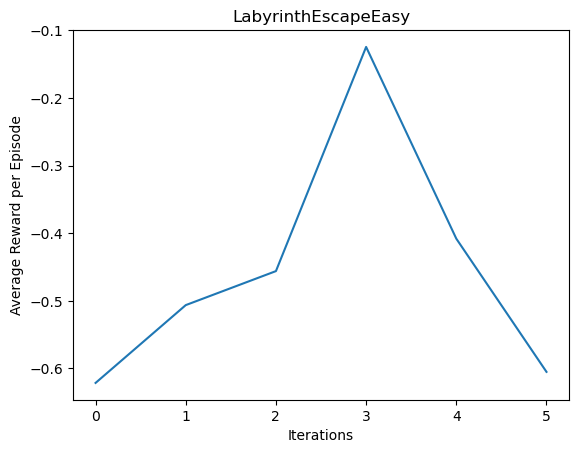

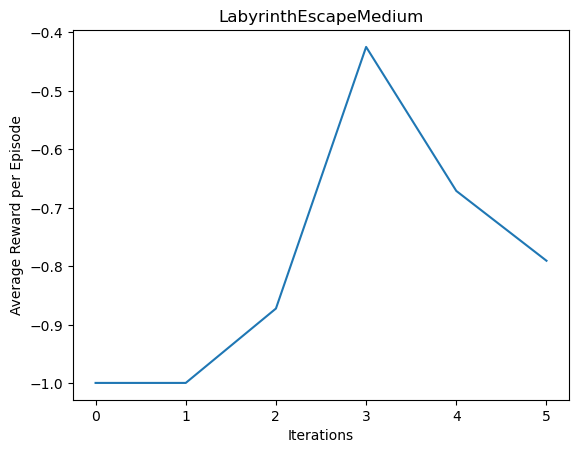

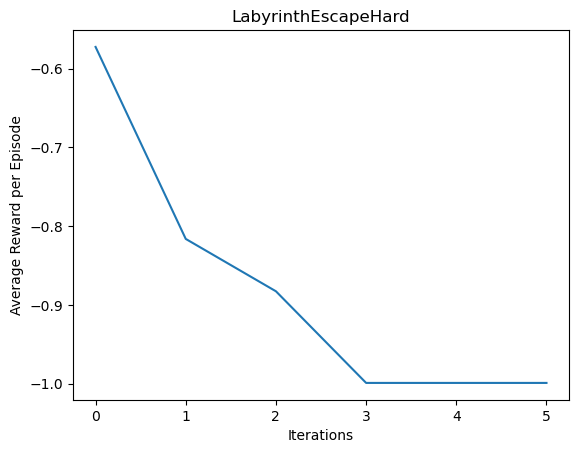

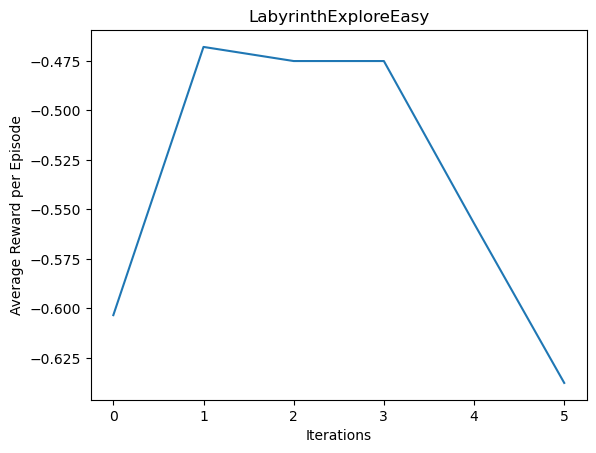

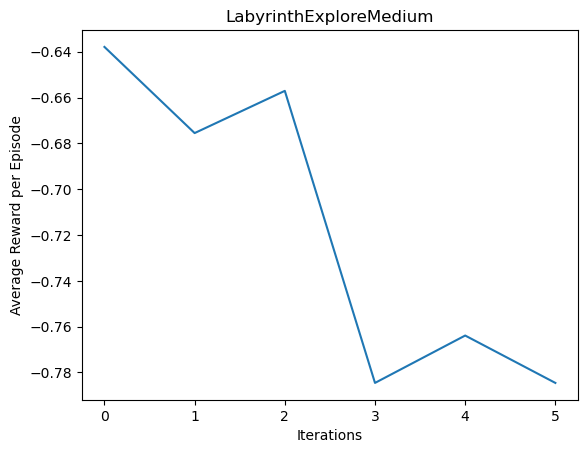

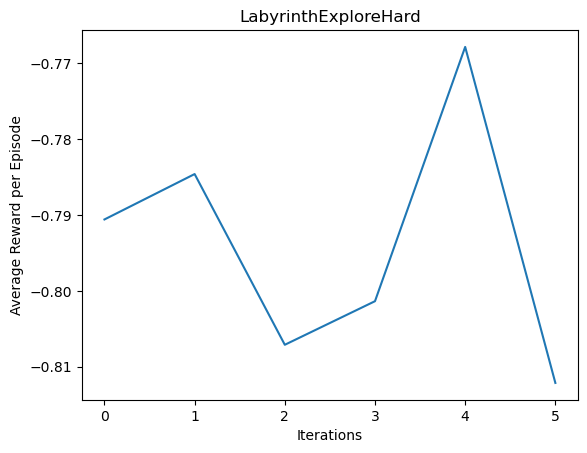

In [14]:
for env in envs:
    plt.plot(mean_reward_per_episode[env])
    plt.title(env)
    plt.xlabel('Iterations')
    plt.ylabel('Average Reward per Episode')
    plt.show()